In [50]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from lightly.transforms import utils
from lightly.data import LightlyDataset
from sklearn.preprocessing import normalize
import json

from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import time

In [38]:
%run model.py
%run utils.py

In [39]:
model_path = "model_16_128_0.0005_20"
input_size = 128
path_to_data = "data/train"

In [40]:
def get_image_path(name):
    return f"data/train/{name}"

In [54]:
def retrieve_top_k(query_image_path, k, model, embeddings_tensor, filenames, transform, input_size):

    query_img = Image.open(query_image_path).convert('RGB')

    query_tensor = transform(query_img).unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        query_embedding = model.backbone(query_tensor).flatten(start_dim=1)

    cos_sim = torch.nn.functional.cosine_similarity(query_embedding, embeddings_tensor)
    
    indices = torch.topk(cos_sim, k=k).indices.cpu().numpy()
    
    plt.figure(figsize=(3*(k+1), 3))
    
    plt.subplot(1, k+1, 1)
    plt.imshow(query_img)
    plt.title("Query")
    plt.axis('off')
    
    for i, idx in enumerate(indices):
        label = get_label(filenames[idx])
        img_path = get_image_path(filenames[idx])
        img = Image.open(img_path).convert('RGB')
        plt.subplot(1, k+1, i+2)
        plt.imshow(img)
        plt.title(f"{label}(Rank {i+1})")
        plt.axis('off')

    plt.savefig(f"results_images/query_{time.time()}.png", bbox_inches='tight', pad_inches=0)
    plt.show()

In [42]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)
dataset = LightlyDataset(input_dir=path_to_data, transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset,  # type: ignore
    batch_size=16,
    shuffle=False,
    drop_last=False,
    num_workers=8,
)
model = SimCLRModel.load_from_checkpoint(f"saved/{model_path}.ckpt")
model.eval()
model.freeze()
embeddings, filenames = generate_embeddings(model, dataloader)

In [43]:
embeddings_tensor = torch.from_numpy(embeddings).float()

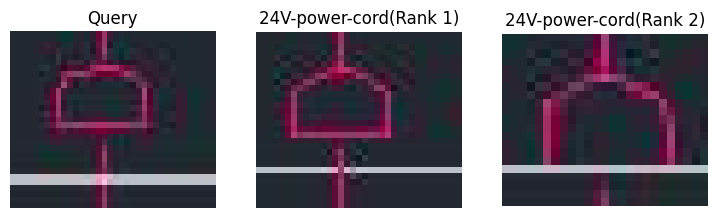

In [52]:
retrieve_top_k(
    query_image_path="data/test/symbol_4_24V-power-cord.png", 
    k=2, 
    model=model, 
    embeddings_tensor=embeddings_tensor, 
    filenames=filenames, 
    transform=transform, 
    input_size=input_size)

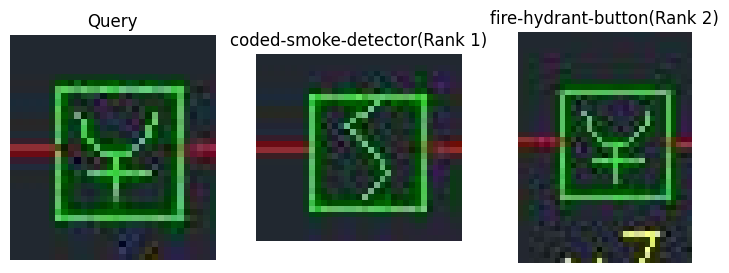

In [53]:
retrieve_top_k(
    query_image_path="data/test/symbol_273_fire-hydrant-button.png", 
    k=2, 
    model=model, 
    embeddings_tensor=embeddings_tensor, 
    filenames=filenames, 
    transform=transform, 
    input_size=input_size)